In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics import Accuracy

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as f_vision

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
transform = transforms.Compose([transforms.CenterCrop(size=200),
                                transforms.Resize(size=224),
                                transforms.ToTensor()])

fruit_trainset = datasets.ImageFolder(root='./data/train', transform=transform)
fruit_testset = datasets.ImageFolder(root='./data/test', transform=transform)

In [3]:
train_batch = 20
test_batch = 10
train_loader = DataLoader(fruit_trainset, batch_size=train_batch, shuffle=True, num_workers=2)
test_loader = DataLoader(fruit_testset, batch_size=test_batch, shuffle=False, num_workers=2)

In [4]:
torch.manual_seed(42)
plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = f_vision.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

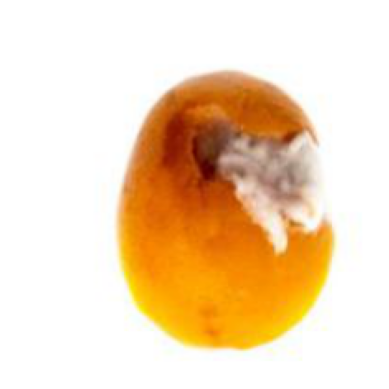

In [5]:
#check train batch
for x_train, y_train in train_loader:
    break
show(x_train[0])

In [6]:
class VGG16(nn.Module):
    def __init__(self, num_class: int, dropout_prob: float):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.max_pool3 = nn.MaxPool2d(kernel_size=2)

        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.max_pool4 = nn.MaxPool2d(kernel_size=2)

        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.max_pool5 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(in_features=512*7*7, out_features=4096)
        self.dropout1 = nn.Dropout(dropout_prob)

        self.fc2 = nn.Linear(in_features=4096, out_features=4096)
        self.dropout2 = nn.Dropout(dropout_prob)

        self.fc3 = nn.Linear(in_features=4096, out_features=num_class)



    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.relu(self.conv2(X))
        X = self.max_pool1(X)

        X = F.relu(self.conv3(X))
        X = F.relu(self.conv4(X))
        X = self.max_pool2(X)

        X = F.relu(self.conv5(X))
        X = F.relu(self.conv6(X))
        X = F.relu(self.conv7(X))
        X = self.max_pool3(X)

        X = F.relu(self.conv8(X))
        X = F.relu(self.conv9(X))
        X = F.relu(self.conv10(X))
        X = self.max_pool4(X)

        X = F.relu(self.conv11(X))
        X = F.relu(self.conv12(X))
        X = F.relu(self.conv13(X))
        X = self.max_pool5(X)

        X = X.view(-1, 512*7*7)

        X = F.relu(self.fc1(X))
        X = self.dropout1(X)

        X = F.relu(self.fc2(X))
        X = self.dropout2(X)

        X = self.fc3(X)
        return X

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
# train model
from torch.optim import RMSprop, Adam
from torch.nn import CrossEntropyLoss
from torchmetrics import Accuracy

model = VGG16(num_class=6, dropout_prob=0.5)
criterion = CrossEntropyLoss()
optimizer = Adam(params=model.parameters(), lr=0.001)
accuracy = Accuracy(task="multiclass", num_classes=6)


# criterion = criterion.to(device)
# model = model.to(device)
# accuracy = accuracy.to(device)

epochs = 2
for _ in range(epochs):
    for x_train, y_train in train_loader:
        # x_train, y_train = x_train.to(device), y_train.to(device)
        y_pred = model(x_train)

        optimizer.zero_grad()
        loss = criterion(y_pred, y_train)
        print('Accuracy -> ', accuracy(y_pred, y_train))
        loss.backward()
        optimizer.step()

Accuracy ->  tensor(0.0500)
Accuracy ->  tensor(0.3000)
Accuracy ->  tensor(0.1000)
Accuracy ->  tensor(0.1500)
Accuracy ->  tensor(0.3000)
Accuracy ->  tensor(0.1500)
Accuracy ->  tensor(0.1000)
Accuracy ->  tensor(0.3000)
Accuracy ->  tensor(0.2000)
Accuracy ->  tensor(0.2500)
Accuracy ->  tensor(0.2500)
Accuracy ->  tensor(0.3000)
Accuracy ->  tensor(0.1500)
Accuracy ->  tensor(0.1500)
Accuracy ->  tensor(0.2000)
Accuracy ->  tensor(0.2500)
Accuracy ->  tensor(0.1500)
Accuracy ->  tensor(0.4500)
Accuracy ->  tensor(0.2500)
Accuracy ->  tensor(0.2000)
Accuracy ->  tensor(0.2500)
Accuracy ->  tensor(0.1500)
Accuracy ->  tensor(0.3500)
Accuracy ->  tensor(0.2000)
Accuracy ->  tensor(0.0500)
Accuracy ->  tensor(0.3000)
Accuracy ->  tensor(0.1500)
Accuracy ->  tensor(0.2500)
Accuracy ->  tensor(0.1500)
Accuracy ->  tensor(0.1000)
Accuracy ->  tensor(0.2000)
Accuracy ->  tensor(0.2500)
Accuracy ->  tensor(0.2000)
Accuracy ->  tensor(0.2500)
Accuracy ->  tensor(0.2000)
Accuracy ->  tensor(

KeyboardInterrupt: 